# Project IND-320
**Name** : _Izza Qamar_

## Links
 - **GitHub Repository** : https://github.com/izzaqamar/Izza_Ind_320.git  

 - **Streamlit App** : https://izza-ind320.streamlit.app/

# Deliverable 3


## Project Overview and AI Usage 

### AI tools

### Project Overview
This section contains brief desciption of jupyter notebook and streamlit app. 

#### Jupter Notebook

#### Streamlit app

## Jupyter Work
- The following sections contain the jupyter tasks. 

In [ ]:
import pandas as pd
import openmeteo_requests
import requests_cache
from retry_requests import retry
from datetime import date
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.tsa.seasonal import STL


In [1]:
import pandas as pd

data={
 'Oslo': {'PriceAreaCode': 'NO1', 'Longitude': 10.7461, 'Latitude': 59.9127},
 'Kristiansand': {'PriceAreaCode': 'NO2', 'Longitude': 7.9956, 'Latitude': 58.1467},
 'Trondheim': {'PriceAreaCode': 'NO3', 'Longitude': 10.3951, 'Latitude': 63.4305},
 'Tromsø': {'PriceAreaCode': 'NO4', 'Longitude': 18.9551, 'Latitude': 69.6489},
 'Bergen': {'PriceAreaCode': 'NO5', 'Longitude': 5.32415, 'Latitude': 60.39299}
}

df = pd.DataFrame(data)
print(df)


                  Oslo Kristiansand Trondheim   Tromsø    Bergen
PriceAreaCode      NO1          NO2       NO3      NO4       NO5
Longitude      10.7461       7.9956   10.3951  18.9551   5.32415
Latitude       59.9127      58.1467   63.4305  69.6489  60.39299


#### Data from API

In [2]:
import openmeteo_requests

import pandas as pd
import requests_cache
from retry_requests import retry
from datetime import date

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

def api_call(coords,year):
    Latitude,Longitude=coords
    start_date=date(year, 1, 1).strftime("%Y-%m-%d")
    end_date=date(year, 12, 31).strftime("%Y-%m-%d")
    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": Latitude,
        "longitude": Longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": ["temperature_2m", "precipitation", "wind_speed_10m", "wind_gusts_10m", "wind_direction_10m"],
        "models": "era5",
    }
    responses = openmeteo.weather_api(url, params=params)
    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]
    print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation: {response.Elevation()} m asl")
    print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")
    #print(f"Response:{response}")

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
    hourly_wind_speed_10m = hourly.Variables(2).ValuesAsNumpy()
    hourly_wind_gusts_10m = hourly.Variables(3).ValuesAsNumpy()
    hourly_wind_direction_10m = hourly.Variables(4).ValuesAsNumpy()

    hourly_data = {"date": pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
        end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = hourly.Interval()),
        inclusive = "left"
    )}

    hourly_data["temperature_2m"] = hourly_temperature_2m
    hourly_data["precipitation"] = hourly_precipitation
    hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
    hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
    hourly_data["wind_direction_10m"] = hourly_wind_direction_10m

    hourly_dataframe = pd.DataFrame(data = hourly_data)
    #print("\nHourly_data\n", hourly_dataframe)
    return hourly_dataframe

coords=(data['Bergen']['Latitude'], data['Bergen']['Longitude'])
year=2019  
df_bergen=api_call(coords,year)
print(df_bergen.head())


Coordinates: 60.5°N 5.25°E
Elevation: 17.0 m asl
Timezone difference to GMT+0: 0s
                       date  temperature_2m  precipitation  wind_speed_10m  \
0 2019-01-01 00:00:00+00:00            6.55            0.5       47.959782   
1 2019-01-01 01:00:00+00:00            6.80            0.9       48.621330   
2 2019-01-01 02:00:00+00:00            6.85            0.7       52.638840   
3 2019-01-01 03:00:00+00:00            6.55            0.6       55.753529   
4 2019-01-01 04:00:00+00:00            6.20            1.0       55.531094   

   wind_gusts_10m  wind_direction_10m  
0       87.839996          277.765076  
1       80.279999          296.375275  
2       85.320000          310.006195  
3       98.639999          314.215271  
4      119.519997          317.101654  


#### Temperature Outliers

In [6]:
# Convert temperature column to plain continuous NumPy array of floats and creating a copy of it.
temp = df_bergen['temperature_2m'].to_numpy(dtype=float, copy=True)
#using dct type 2 and using 'norm' so both forward and inverse are scaled so that the transform is unitary,

temp_dct = dct(temp, type=2, norm='ortho')
#temp_dct tells you how much of each "cosine wave" is present in your signal.
print(temp_dct)
# 2. High-pass filter in frequency domain
dct_cutoff_hours = 240 # remove variations longer than 10 days
N = len(temp)
k_cut = int(2 * N / dct_cutoff_hours)
#You remove all cosine components that vary slower than once every 30 days.
#Removed: frequencies < 1/(30 days) → slow, seasonal trend
#Filtering changes the content (which frequencies are present), not the sampling rate or number of data points.
temp_dct_hp = temp_dct.copy()
print(temp_dct_hp )
temp_dct_hp[:k_cut] = 0  # zero out slow components

# 3. Inverse DCT to get seasonally adjusted temperature variations (SATV)
temp_satv = idct(temp_dct_hp, type=2, norm='ortho')
print(temp_satv )

[ 8.28009563e+02 -1.09254354e+02 -3.66209287e+02 ...  4.05107613e-01
  9.04902089e-02  5.36013904e-02]
[ 8.28009563e+02 -1.09254354e+02 -3.66209287e+02 ...  4.05107613e-01
  9.04902089e-02  5.36013904e-02]
[ 1.26580172  1.51562991  1.56528612 ... -0.06770959  0.33096495
  0.33030205]


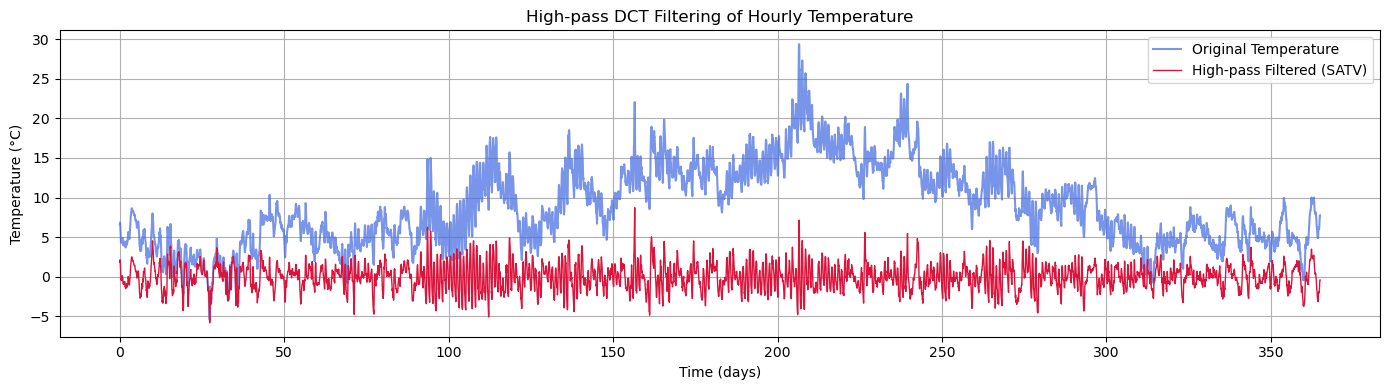

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

df_bergen['date'] = pd.to_datetime(df_bergen['date'])
# 1️⃣ Convert temperature column to NumPy array
temp = df_bergen['temperature_2m'].to_numpy(dtype=float, copy=True)
N = len(temp)

# 2️⃣ Forward DCT (Type-II)
temp_dct = dct(temp, type=2, norm='ortho')

# 3️⃣ High-pass filter setup
dct_cutoff_hours = 168  # 10 days
k_cut = int(2 * N / dct_cutoff_hours)

# Copy and zero out the low-frequency (slow) components
temp_dct_hp = temp_dct.copy()
temp_dct_hp[:k_cut] = 0

# 4️⃣ Inverse DCT → Seasonally Adjusted Temperature Variations (SATV)
temp_satv = idct(temp_dct_hp, type=2, norm='ortho')

# 5️⃣ Prepare a time axis (assuming hourly data)
time = np.arange(N) / 24  # days

# 6️⃣ Plot original vs. high-pass filtered signal
plt.figure(figsize=(14,4))

plt.plot(time, temp, color='royalblue', label='Original Temperature', alpha=0.7)
plt.plot(time, temp_satv, color='crimson', label='High-pass Filtered (SATV)', linewidth=1)

plt.title("High-pass DCT Filtering of Hourly Temperature")
plt.xlabel("Time (days)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


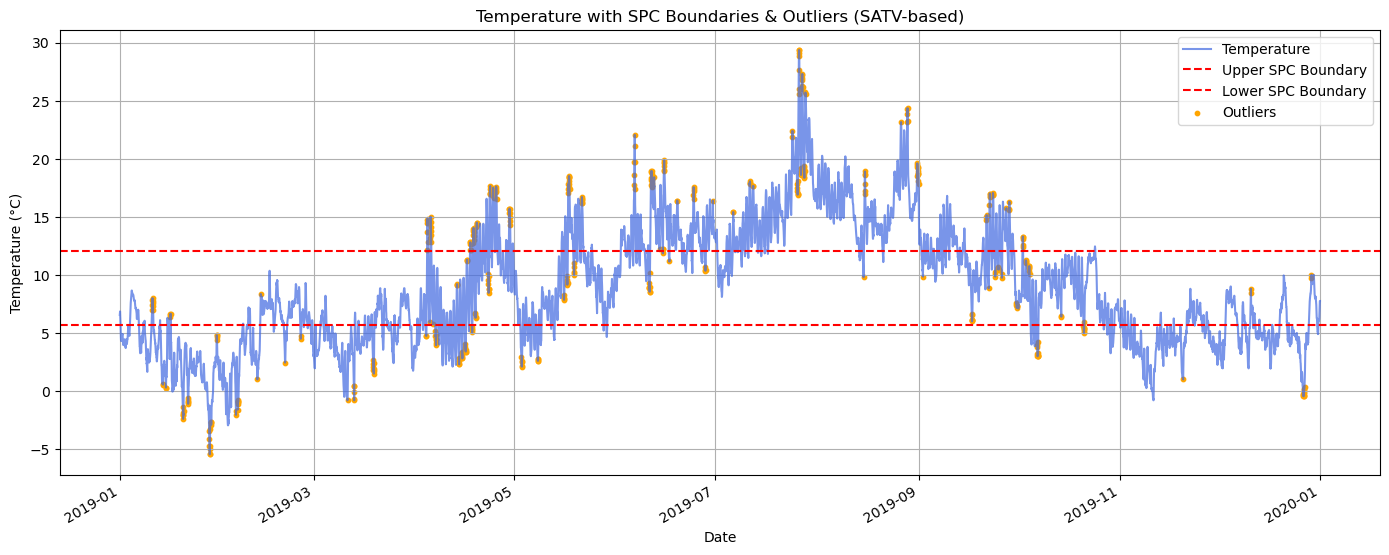

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

# --- 0️⃣ Load your DataFrame (example) ---
# df_bergen = pd.read_csv("your_file.csv")
# Ensure 'date' is datetime and 'temperature_2m' is float
df_bergen['date'] = pd.to_datetime(df_bergen['date'])
temp = df_bergen['temperature_2m'].to_numpy(dtype=float, copy=True)
dates = df_bergen['date']
N = len(temp)

# --- 1️⃣ Forward DCT ---
temp_dct = dct(temp, type=2, norm='ortho')

# --- 2️⃣ High-pass filter setup ---
dct_cutoff_hours = 168  # 1 week
k_cut = int(2 * N / dct_cutoff_hours)

# Zero out slow (low-frequency) components
temp_dct_hp = temp_dct.copy()
temp_dct_hp[:k_cut] = 0

# --- 3️⃣ Inverse DCT → SATV ---
temp_satv = idct(temp_dct_hp, type=2, norm='ortho')

# --- 4️⃣ Robust statistics (from SATV) ---
satv_median = np.median(temp_satv)
satv_mad = np.median(np.abs(temp_satv - satv_median))

upper_bound = satv_median + 3 * satv_mad
lower_bound = satv_median - 3 * satv_mad

# --- 5️⃣ Identify outliers ---
predict = (temp_satv > upper_bound) | (temp_satv < lower_bound)

# --- 6️⃣ Plot original temperature with SPC boundaries & outliers ---
plt.figure(figsize=(14,6))
plt.plot(dates, temp, color='royalblue', label='Temperature', alpha=0.7)


# SPC boundaries (shifted by mean of temperature)
plt.axhline(np.mean(temp) + upper_bound, color='red', linestyle='--', label='Upper SPC Boundary')
plt.axhline(np.mean(temp) + lower_bound, color='red', linestyle='--', label='Lower SPC Boundary')

# Outliers
plt.scatter(dates[predict], temp[predict], color='orange', s=10, label='Outliers')

plt.title("Temperature with SPC Boundaries & Outliers (SATV-based)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Optional: improve date formatting on x-axis
plt.gcf().autofmt_xdate()

plt.show()

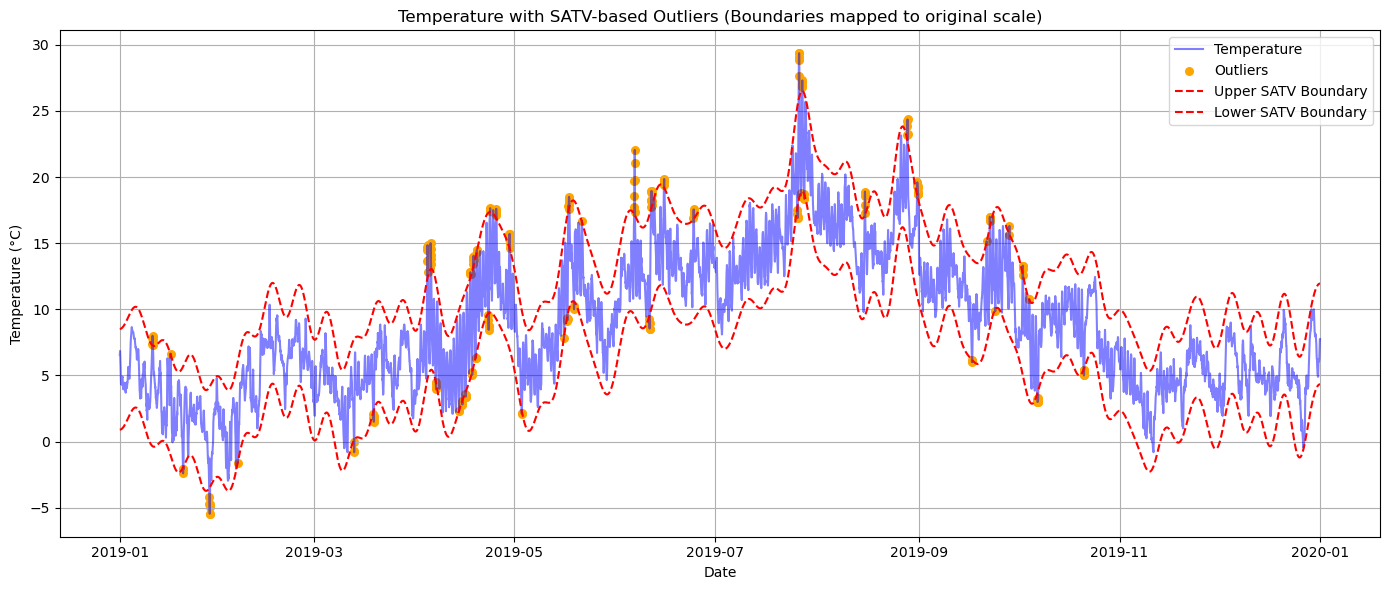

Summary 
    Trimmed mean (SATV): -0.01
    Trimmed std (SATV): 1.27
    Upper SPC bound (SATV): 3.80
    Lower SPC bound (SATV): -3.82
    Number of inliers: 8551
    Number of outliers: 209  


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

def temp_outliers(dct_cutoff_hours=168,n_std=3):
    
    # Original temperature converted to numpy array to pass to dct
    temp = df_bergen['temperature_2m'].to_numpy(dtype=float)
    dates = pd.to_datetime(df_bergen['date'])

    #  DCT type 2
    N = len(temp)
    temp_dct = dct(temp, type=2, norm='ortho')

    # cutoff (default:weekly)
    k_cut = int(2 * N / dct_cutoff_hours)

    # High-pass filtering and SATV 
    temp_dct_hp = temp_dct.copy()
    temp_dct_hp[:k_cut] = 0
    temp_satv = idct(temp_dct_hp, type=2, norm='ortho')

    # SATV robust SPC boundaries 

    import scipy.stats as stats
    #5% of the most extreme values trimmed
    trim_proportion = 0.05
    n_std = 3

    trimmed_mean_val = stats.trim_mean(temp_satv, trim_proportion)
    sorted_data = np.sort(temp_satv)
    #Number of values to be trimmed
    cut = int(trim_proportion * N)
    #keeps 90% of middle values and gives trimmed std for population
    trimmed_std_val = np.std(sorted_data[cut:N-cut], ddof=0)

    #Calculating boundaries
    upper_bound = trimmed_mean_val + n_std * trimmed_std_val
    lower_bound = trimmed_mean_val - n_std * trimmed_std_val

    # Identifying outliers 
    outliers_mask = (temp_satv > upper_bound) | (temp_satv < lower_bound)
    inliers_mask = ~outliers_mask

    # original temperatures corresponding to inliers and outliers

    inliers = temp[inliers_mask]    
    outliers = temp[outliers_mask]  

    # To Map SATV boundaries to original temperature scale we find trend from Low-pass (slow) component extraction
    temp_dct_low = temp_dct.copy()
    temp_dct_low[k_cut:] = 0  
    temp_lowfreq = idct(temp_dct_low, type=2, norm='ortho') # trend

    upper_thresh_orig = temp_lowfreq + upper_bound
    lower_thresh_orig = temp_lowfreq + lower_bound

    # Plotting original temperature with SATV-based outliers 
    fig=plt.figure(figsize=(14,6))
    plt.plot(dates, temp, color='blue', label='Temperature', alpha=0.5)
    plt.scatter(dates[outliers_mask], temp[outliers_mask], color='orange', s=30, label='Outliers')

    # Plotting dynamic SATV-based thresholds
    plt.plot(dates, upper_thresh_orig, color='red', linestyle='--', label='Upper SATV Boundary')
    plt.plot(dates, lower_thresh_orig, color='red', linestyle='--', label='Lower SATV Boundary')

    plt.title("Temperature with SATV-based Outliers (Boundaries mapped to original scale)")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    #  Summary 
    summary = f"""Summary 
    Trimmed mean (SATV): {trimmed_mean_val:.2f}
    Trimmed std (SATV): {trimmed_std_val:.2f}
    Upper SPC bound (SATV): {upper_bound:.2f}
    Lower SPC bound (SATV): {lower_bound:.2f}
    Number of inliers: {len(inliers)}
    Number of outliers: {len(outliers)}  """
    
    return plt,summary

temp,summary=temp_outliers(dct_cutoff_hours=168,n_std=3) 
temp.show()
print(summary) 




#### Precipitation Anomalies

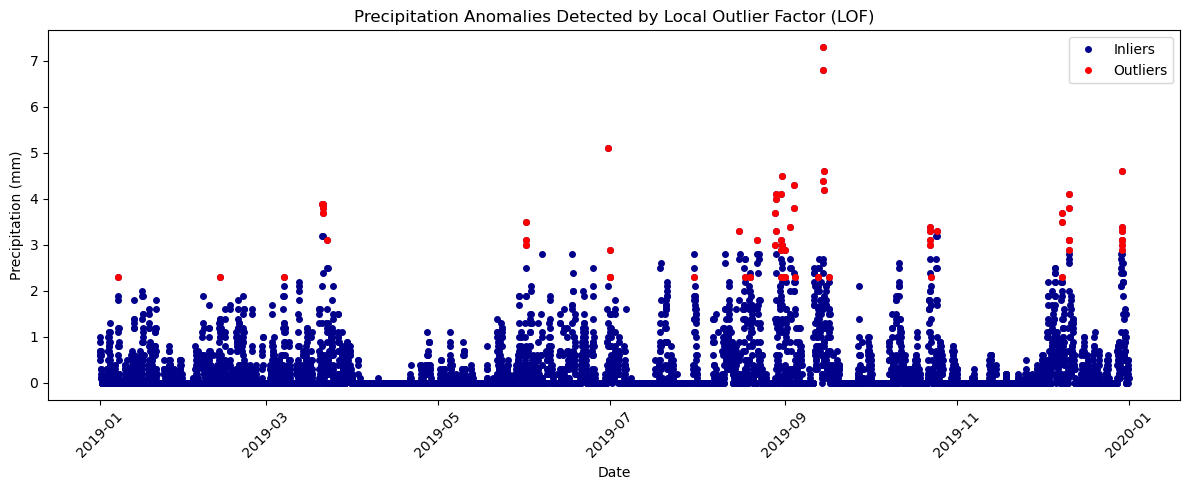

 Summary
      Proportion of outliers 0.01
      Number of inliers: 8692 
      Number of outliers: 68


In [55]:
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import numpy as np

def precipitation_anomalies(outlier_proportion=0.01):
    
    # Ensure data is in 2D shape for LOF
    precipitation = [[x] for x in df_bergen['precipitation']]

    # Apply Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=20, contamination=outlier_proportion)
    pred_labels = lof.fit_predict(precipitation)

    # LOF returns -1 for outliers and 1 for inliers (boolean values)
    outliers = pred_labels == -1
    inliers = pred_labels == 1

    # Plotting 
    fig = plt.figure(figsize=(12, 5))

    # Plot all data points (inliers in blue)
    plt.plot(df_bergen['date'], df_bergen['precipitation'], 'o', color='darkblue', markersize=4, label='Inliers')

    # Plot outliers (in red)
    plt.plot(df_bergen['date'][outliers], df_bergen['precipitation'][outliers], 
             'o', color='red', markersize=4, label='Outliers')

    # Axis labels and title
    plt.title('Precipitation Anomalies Detected by Local Outlier Factor (LOF)')
    plt.xlabel('Date')
    plt.ylabel('Precipitation (mm)')
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.tight_layout()
    

    # Summary
    summary = f''' Summary
      Proportion of outliers {outlier_proportion}
      Number of inliers: {np.sum(inliers)} 
      Number of outliers: {np.sum(outliers)}'''

    return plt,summary

# Run it
precipitation,summary = precipitation_anomalies(outlier_proportion=0.01)
precipitation.show()
print(summary)


#### LOESS

In [ ]:
#Reading csv as dataframe
production_df=pd.read_csv(r"production_elhub.csv",
                          parse_dates=['endTime','startTime','lastUpdatedTime'],
                          dtype={'priceArea': 'string', 'productionGroup': 'string'})

#Displaying descriptive statistics of dataframe 
print(production_df.info())
print(production_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215353 entries, 0 to 215352
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   endTime          215353 non-null  datetime64[ns, UTC]
 1   lastUpdatedTime  215353 non-null  datetime64[ns, UTC]
 2   priceArea        215353 non-null  string             
 3   productionGroup  215353 non-null  string             
 4   quantityKwh      215353 non-null  float64            
 5   startTime        215353 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](3), float64(1), string(2)
memory usage: 9.9 MB
None


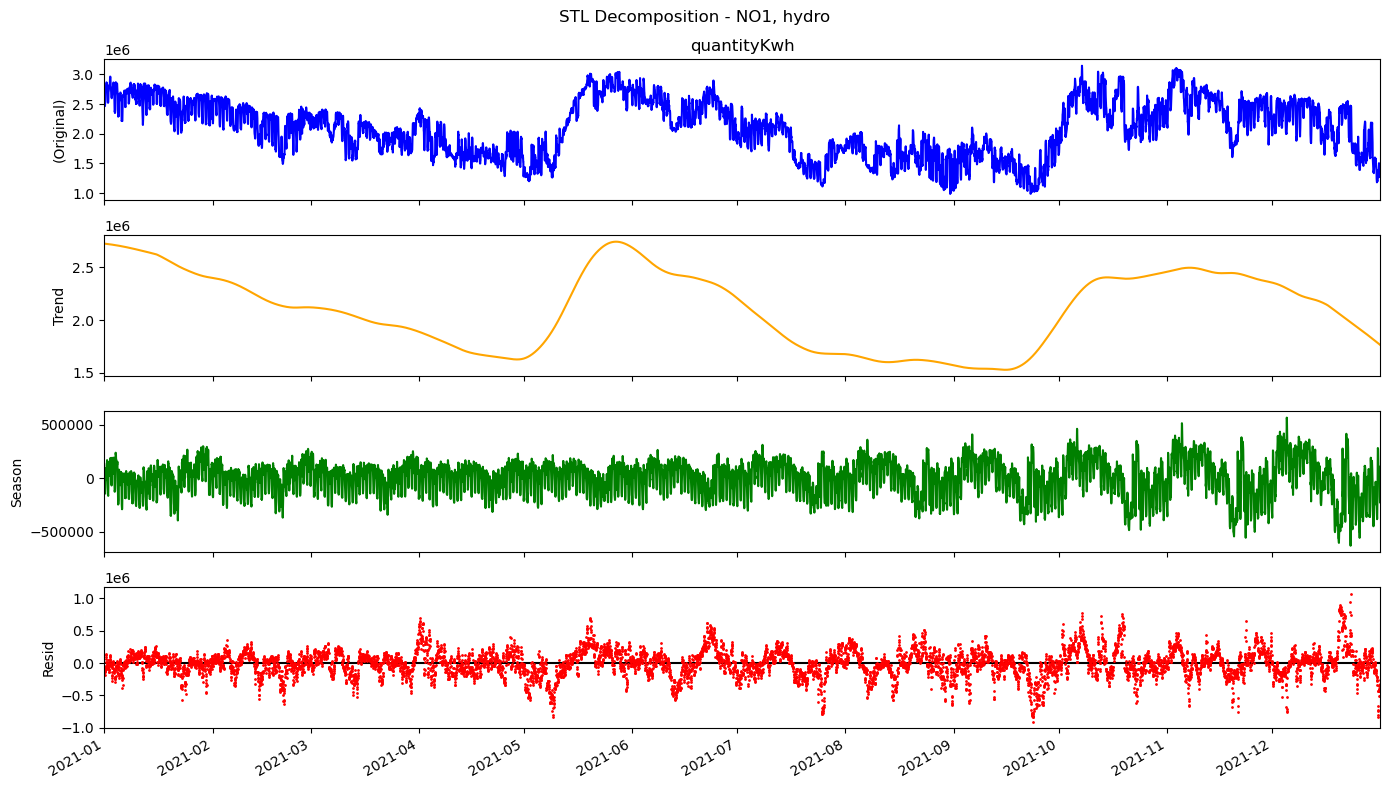

In [ ]:
#Performing Seasonal-Trend decomposition using LOESS (STL)

from statsmodels.tsa.seasonal import STL
#default monthly period and True robust
def stl_Loess(priceArea='NO1',productionGroup='hydro',period=720,seasonal_smoother=723,trend_smoother=723,robust=True):
    filtered_stl_df = production_df.copy()
    if priceArea is not None:
        filtered_stl_df = filtered_stl_df[filtered_stl_df['priceArea'] == priceArea]
    if productionGroup is not None:
        filtered_stl_df = filtered_stl_df[filtered_stl_df['productionGroup'] == productionGroup]
    
    # Setting datetime index
    filtered_stl_df = filtered_stl_df.set_index('startTime')

    stl = STL(filtered_stl_df["quantityKwh"], period=period, seasonal=seasonal_smoother, trend=trend_smoother, robust=robust)
    
    # Contains the components and a plot function
    res = stl.fit() 
    fig = res.plot()
    
    #Resizing figure 
    fig.set_size_inches(14, 8)   
    fig.autofmt_xdate()
   
    # Get all Axes (subplots) from the figure to recolour individually
    axes = fig.get_axes()
    
    axes[0].lines[0].set_color("blue")
    axes[0].set_ylabel("Original")      
    
    axes[1].lines[0].set_color("orange")    
    
    axes[2].lines[0].set_color("green")     
    
    axes[3].lines[0].set_color("red")  
    axes[3].lines[0].set_markersize(1) 
    
    plt.suptitle(f"STL Decomposition - {priceArea}, {productionGroup}", fontsize=12)
    plt.tight_layout()
    #plt.show()
    
    return fig,res

fig, decomposition = stl_Loess(priceArea='NO1',productionGroup='hydro',period=720,seasonal_smoother=723,trend_smoother=723,robust=True)
plt.show()  # Display the returned figure

#### Spectogram

In [ ]:
print(production_df.info())

In [ ]:
from scipy.signal import spectrogram
def plot_hourly_spectrogram(priceArea='NO1',productionGroup='hydro', window_length=168, window_overlap=84):
    df_spectogram = production_df.copy()
    if priceArea is not None:
        df_spectogram = df_spectogram[df_spectogram['priceArea'] == priceArea]
    if productionGroup is not None:
        df_spectogram = df_spectogram[df_spectogram['productionGroup'] == productionGroup]
        
    df_spectogram = df_spectogram.set_index('startTime')
    data=df_spectogram["quantityKwh"].to_numpy()
    time_index = df_spectogram.index
    fs = 1           # 1 sample per hour
    # Compute spectrogram
    f, t_spec, Sxx = spectrogram(data, fs=fs, nperseg=window_length, noverlap=window_overlap)

        # Convert t_spec (in hours) to actual timestamps
    t_dates = time_index[0] + pd.to_timedelta(t_spec, unit='h')
        


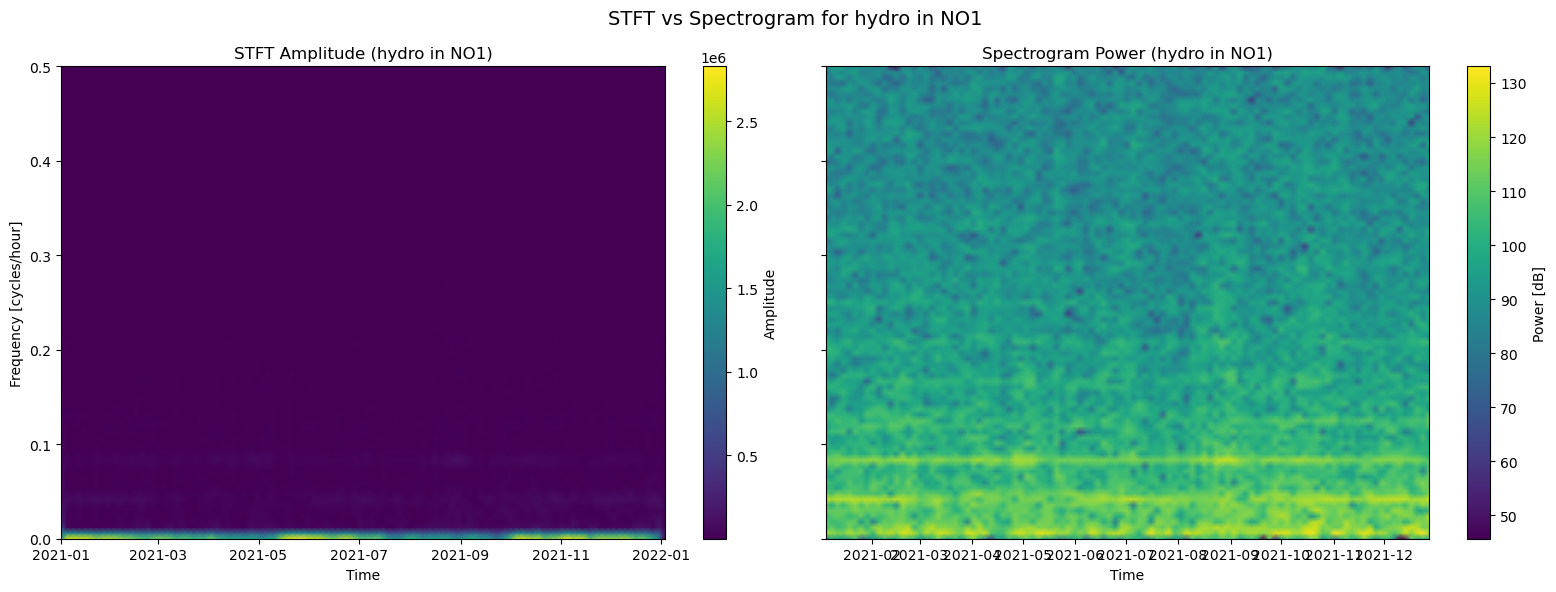

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import stft, spectrogram

def plot_stft_vs_spectrogram_filtered(priceArea='NO1', productionGroup='hydro', 
                                      window_length=168, window_overlap=84, cmap='viridis'):
    """
    Plot STFT amplitude vs Spectrogram power for filtered electricity data.

    Parameters:
    -----------
    priceArea : str
        Price area to filter the data
    productionGroup : str
        Production group to filter the data
    window_length : int
        Window length in samples (default 168 = 1 week)
    window_overlap : int
        Overlap between windows (default 84 = 50%)
    cmap : str
        Colormap for plotting
    """
    # Copy and filter dataframe
    df_filtered = production_df.copy()
    
    if priceArea is not None:
        df_filtered = df_filtered[df_filtered['priceArea'] == priceArea]
    if productionGroup is not None:
        df_filtered = df_filtered[df_filtered['productionGroup'] == productionGroup]
    
    # Ensure datetime index
    df_filtered = df_filtered.set_index('startTime')
    
    # Extract signal
    x = df_filtered['quantityKwh'].to_numpy()
    time_index = df_filtered.index
    
    # Sampling frequency
    fs = 1  # 1 sample per hour
    
    # ---- STFT ----
    f_stft, t_stft, Zxx = stft(x, fs=fs, nperseg=window_length, noverlap=window_overlap)
    t_stft_dates = time_index[0] + pd.to_timedelta(t_stft, unit='h')
    
    # ---- Spectrogram ----
    f_spec, t_spec, Sxx = spectrogram(x, fs=fs, nperseg=window_length, noverlap=window_overlap)
    t_spec_dates = time_index[0] + pd.to_timedelta(t_spec, unit='h')
    
    # ---- Plot ----
    fig, axs = plt.subplots(1, 2, figsize=(16,6), sharey=True)
    
    # STFT amplitude (linear)
    pcm1 = axs[0].pcolormesh(t_stft_dates, f_stft, np.abs(Zxx), shading='gouraud', cmap=cmap)
    axs[0].set_title(f'STFT Amplitude ({productionGroup} in {priceArea})')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Frequency [cycles/hour]')
    fig.colorbar(pcm1, ax=axs[0], label='Amplitude')
    
    # Spectrogram power (dB)
    pcm2 = axs[1].pcolormesh(t_spec_dates, f_spec, 10*np.log10(Sxx), shading='gouraud', cmap=cmap)
    axs[1].set_title(f'Spectrogram Power ({productionGroup} in {priceArea})')
    axs[1].set_xlabel('Time')
    fig.colorbar(pcm2, ax=axs[1], label='Power [dB]')
    
    plt.suptitle(f"STFT vs Spectrogram for {productionGroup} in {priceArea}", fontsize=14)
    plt.tight_layout()
    plt.show()
# Example usage
plot_stft_vs_spectrogram_filtered(priceArea='NO1', productionGroup='hydro', 
                                  window_length=168, window_overlap=84) 